![title](ANTI-INFECTIVES-RGB_200pc.png)

# Analysis of Senescent Proteins in Human

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee


## Aims
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane. <b>Note for the boss:</b> What about extracellular proteins such as collagen?

In [7]:
import sys
print(sys.version)
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
Populating the interactive namespace from numpy and matplotlib


In [8]:
#iteresting ref for tmt/ibaq data normalization
#https://pwilmart.github.io/IRS_normalization/understanding_IRS.html

#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import missingno as msno
from scipy import stats
import gc
import warnings
warnings.filterwarnings("ignore")

In [9]:
#define helping function
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text

def make_scatter_matrix(in_df):
    sns.set(font_scale = 1)
    #sns.set(style="white")
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.3f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    
    g = sns.PairGrid(in_df, palette=["red"]) 
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False) 
    g.map_lower(sns.kdeplot, cmap="Blues_d") 
    g.map_lower(corrfunc)
    plt.show()


def make_pca(in_df, palette, top=500):
    cols = in_df.columns
    pca = PCA(n_components=2)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('PCA',size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    plt.show()
    
def make_mds(in_df, palette, top=500):
    cols = in_df.columns
    pca = MDS(n_components=2,metric=True)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols,columns =['pc_1','pc_2'] )
    
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)

    plt.show()


## Labeling efficiency
We can get an indirect estimate of the labelling efficiency by taking the ratio of the number of peptides with zero TMT intensity vs the total peptides identified. We can estimate the ratio for all the TMT channels.

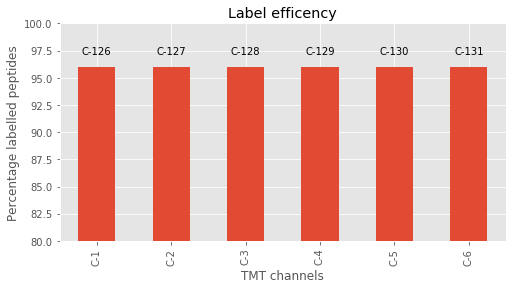

In [10]:
TXT_PATH = 'D:\\michele\\old_age\\raw_4x\\combined\\txt\\'
path=TXT_PATH+'evidence.txt'
evi = pd.read_table(path)
temp = evi[['Reporter intensity corrected {}'.format(n) for n in range(1,7)]]
fig,ax=plt.subplots(figsize=(8,4))
(temp.replace(0,np.nan).notnull().sum(axis=0)/temp.shape[0]*100).plot(kind='bar',ax=ax)
ax.set_xticklabels(['C-'+str(n) for n in [1,2,3,4,5,6]])
ax.set_xlabel('TMT channels')
ax.set_ylabel('Percentage labelled peptides')
ax.set_title('Label efficency')
ax.set_ylim(80,100)
rects = ax.patches
labels = ["C-%d" % i for i in [126,127,128,129,130,131]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')

plt.show()

In [13]:
evi['Modifications'].value_counts().head()

Unmodified           139313
TMT6plex-ST-var       45072
Oxidation (M)         29465
Formyl                21687
2 TMT6plex-ST-var      7377
Name: Modifications, dtype: int64

In [14]:
evi['meanC']=evi[['Reporter intensity corrected {}'.format(n) for n in range(1,4)]].mean(axis=1,skipna=True)
evi['meanS']=evi[['Reporter intensity corrected {}'.format(n) for n in range(4,7)]].mean(axis=1,skipna=True)
evi['fc']= np.log2((evi['meanS']+1)/(evi['meanC']+1))


count    272064.000000
mean          0.062668
std           0.455445
min         -11.824375
25%          -0.129861
50%           0.043886
75%           0.261868
max          11.794957
Name: fc, dtype: float64


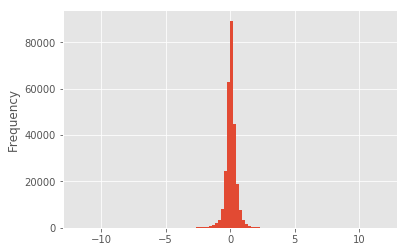

In [15]:
print(evi['fc'].describe())
evi['fc'].plot(kind='hist',bins=100)

In [16]:
print(evi['Modifications'].value_counts().head())
temp = evi['Modifications'].value_counts()
temp = temp/temp[0]
temp.head(10)

Unmodified           139313
TMT6plex-ST-var       45072
Oxidation (M)         29465
Formyl                21687
2 TMT6plex-ST-var      7377
Name: Modifications, dtype: int64


Unmodified                          1.000000
TMT6plex-ST-var                     0.323530
Oxidation (M)                       0.211502
Formyl                              0.155671
2 TMT6plex-ST-var                   0.052953
Deamidation (NQ)                    0.052881
TMT6plex-ST-var,Formyl              0.032854
Oxidation (M),TMT6plex-ST-var       0.032445
Deamidation (NQ),TMT6plex-ST-var    0.017077
Oxidation (M),Formyl                0.014371
Name: Modifications, dtype: float64

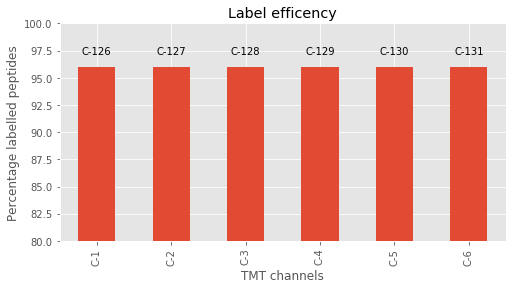

In [17]:
TXT_PATH = 'D:\\michele\\old_age\\raw_4x\\combined\\txt\\'
path=TXT_PATH+'evidence.txt'
evi = pd.read_table(path)
temp = evi[['Reporter intensity corrected {}'.format(n) for n in range(1,7)]]
fig,ax=plt.subplots(figsize=(8,4))
(temp.replace(0,np.nan).notnull().sum(axis=0)/temp.shape[0]*100).plot(kind='bar',ax=ax)
ax.set_xticklabels(['C-'+str(n) for n in [1,2,3,4,5,6]])
ax.set_xlabel('TMT channels')
ax.set_ylabel('Percentage labelled peptides')
ax.set_title('Label efficency')
ax.set_ylim(80,100)
rects = ax.patches
labels = ["C-%d" % i for i in [126,127,128,129,130,131]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')
plt.show()

In [18]:
del evi
gc.collect()

2776

In [19]:
print(TXT_PATH)
path = TXT_PATH+'MsmsScans.txt'
MsmsScans = pd.read_table(path)

path = TXT_PATH+'msms.txt'
msms = pd.read_table(path)

D:\michele\old_age\raw_4x\combined\txt\


In [20]:
from scipy.stats import ttest_ind
print(MsmsScans['Identified'].value_counts())
MsmsScans['ave_S'] = MsmsScans[['Reporter intensity corrected '+ str(n) for n in range(1,4)]].replace(0,np.nan).mean(axis=1,skipna=True)
MsmsScans['ave_C'] = MsmsScans[['Reporter intensity corrected '+ str(n) for n in range(4,7)]].replace(0,np.nan).mean(axis=1,skipna=True)
MsmsScans['logFC'] = np.log2((MsmsScans['ave_C']+1)/(MsmsScans['ave_S']+1))
#MsmsScans['logFC'].plot(kind='hist')
select = MsmsScans[MsmsScans['logFC']<-2]
select = select[select['Charge'] >=2]
print(select.shape)

cols =['Reporter intensity corrected '+ str(n) for n in range(1,7)]+['logFC',
                                                                     'Raw file',
                                                                     'Scan number',
                                                                    'Retention time',
                                                                    'm/z','Charge', 'Type']
res = ttest_ind(select[cols[0:3]].T,select[cols[3:6]].T)
select['pval'] = res.pvalue 
select['statistic'] = res.statistic 
print(select['Raw file'].value_counts())
select[cols+['pval','statistic']].sort_values('logFC').head(5)

-    489197
+    315821
Name: Identified, dtype: int64
(2277, 59)
RPT-PS-TMT-Frac-19    173
RPT-PS-TMT-Frac-17    152
RPT-PS-TMT-Frac-10    137
RPT-PS-TMT-Frac-5     133
RPT-PS-TMT-Frac-20    131
RPT-PS-TMT-Frac-1     119
RPT-PS-TMT-Frac-12    117
RPT-PS-TMT-Frac-6     116
RPT-PS-TMT-Frac-11    113
RPT-PS-TMT-Frac-14    110
RPT-PS-TMT-Frac-7     103
RPT-PS-TMT-Frac-16    101
RPT-PS-TMT-Frac-18    101
RPT-PS-TMT-Frac-4     100
RPT-PS-TMT-Frac-8     100
RPT-PS-TMT-Frac-3      99
RPT-PS-TMT-Frac-2      97
RPT-PS-TMT-Frac-15     97
RPT-PS-TMT-Frac-9      95
RPT-PS-TMT-Frac-13     83
Name: Raw file, dtype: int64


,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,logFC,Raw file,Scan number,Retention time,m/z,Charge,Type,pval,statistic
293735,848.14,161220.00,1475.7,0.0,0.00,225.05,-7.913884,RPT-PS-TMT-Frac-8,24470,67.347,376.768639,2,MULTI,0.365246,1.020365
630603,0.00,496.32,74445.0,0.0,226.92,0.00,-7.361129,RPT-PS-TMT-Frac-16,40926,102.460,398.813838,2,MULTI,0.370926,1.006954
293977,794.12,163960.00,1691.8,0.0,317.61,379.47,-7.310444,RPT-PS-TMT-Frac-8,24746,67.943,376.768649,2,MULTI,0.365982,1.018618
676877,0.00,0.00,20284.0,203.9,262.61,0.00,-6.436190,RPT-PS-TMT-Frac-17,44144,109.140,398.813915,2,MULTI,0.383919,0.976933
630871,0.00,345.14,37383.0,280.6,177.28,0.00,-6.358316,RPT-PS-TMT-Frac-16,41216,103.060,398.813838,2,MULTI,0.373234,1.001554


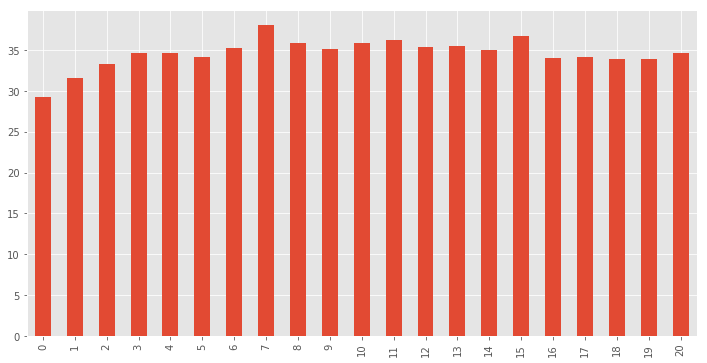

In [23]:
fig,ax=plt.subplots(figsize=(12,6))
path = TXT_PATH+'summary.txt'
summary = pd.read_table(path)
summary['MS/MS Identified [%]'].plot(kind='bar')
plt.show()

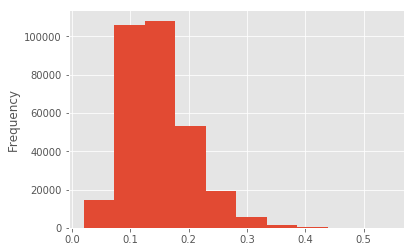

In [22]:
msms['Peak coverage'].plot(kind='hist')

## Dataset analysis

In [230]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join(TXT_PATH, 'proteinGroups.txt'))
df.head()
#print(df.columns)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
data=df[cols]
data.columns = ['S1','S2','S3', 'C1','C2','C3']

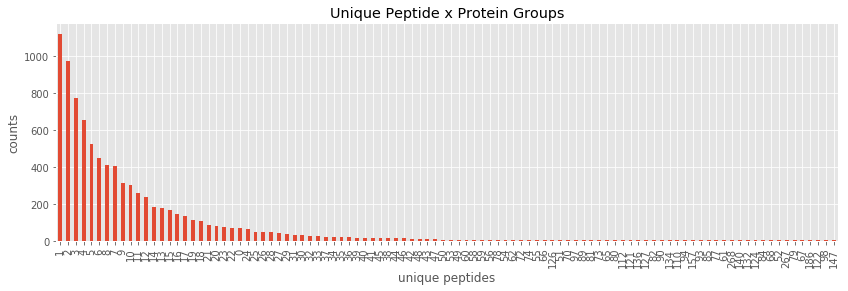

In [26]:
fig,ax=plt.subplots(figsize=(14,4))
df['Unique peptides'].value_counts().plot(kind='bar',ax=ax)
plt.title('Unique Peptide x Protein Groups')
ax.set_xlabel('unique peptides')
ax.set_ylabel('counts')
plt.show()

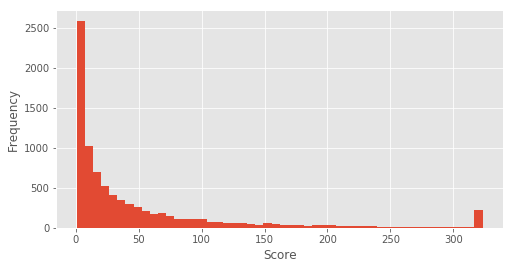

In [27]:
fig,ax=plt.subplots(figsize=(8,4))
df['Score'].plot(kind='hist',ax=ax,bins=50)
ax.set_xlabel('Score')
plt.show()

### Missing Data Analysis

(8491, 6)


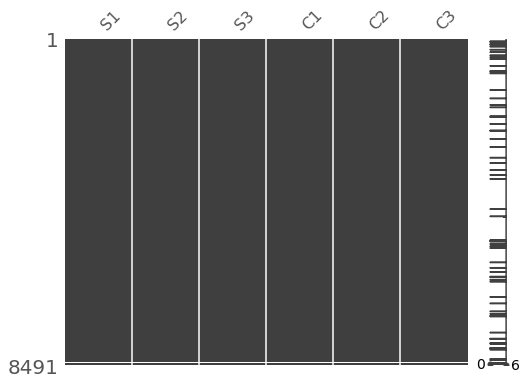

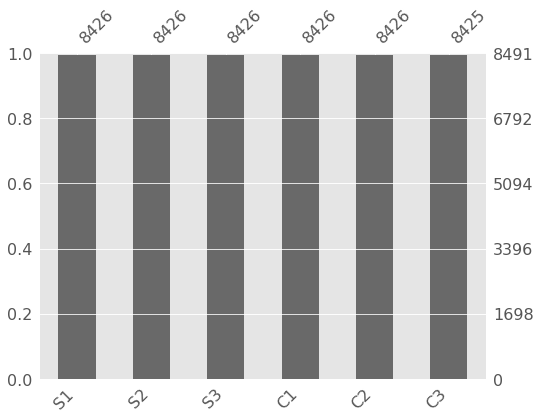

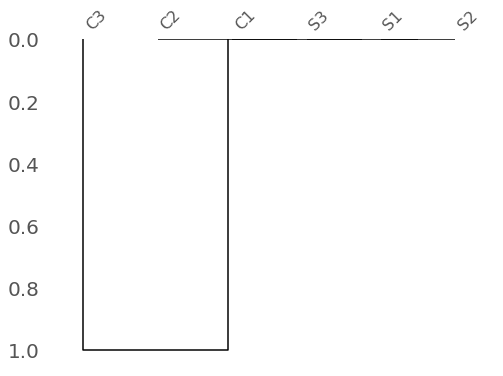

(8491, 6)


In [28]:
print(data.shape)
data=data.replace(0, np.nan)
msno.matrix(data, figsize=(8, 6))
#plt.title('Missing Data')
plt.show()

msno.bar(data, figsize=(8, 6))
plt.show()

msno.dendrogram(data, figsize=(8, 6))
plt.show()

data=data.replace(np.nan,0)
data = data.dropna(how='all')
print(data.shape)

This picture show that we identified an 6614 protein groups. For the moment we do not use any filter for the number of unique peptides

In [29]:
#how many protein group with two unique peptides?
df[df['Unique peptides']>=2].shape

(7303, 82)

In [31]:
#df['Protein IDs']

In [32]:
#df['myco']=[1 if 'MYCO' in n.split('|')[1] else 0 for n in df['Protein IDs']]
#df[df['myco']==1]['Score'].plot(kind='hist',histtype='step')
#df[df['myco']==0]['Score'].plot(kind='hist',histtype='step')

### Average Intensity

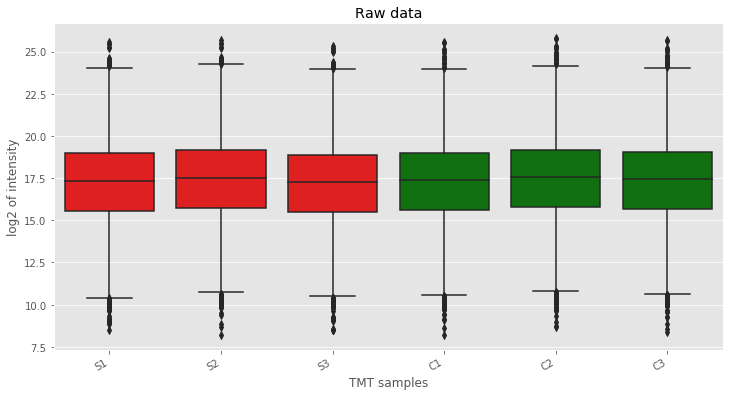

In [33]:
my_pal = ["r"]*3+["g"]*3
fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Raw data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()

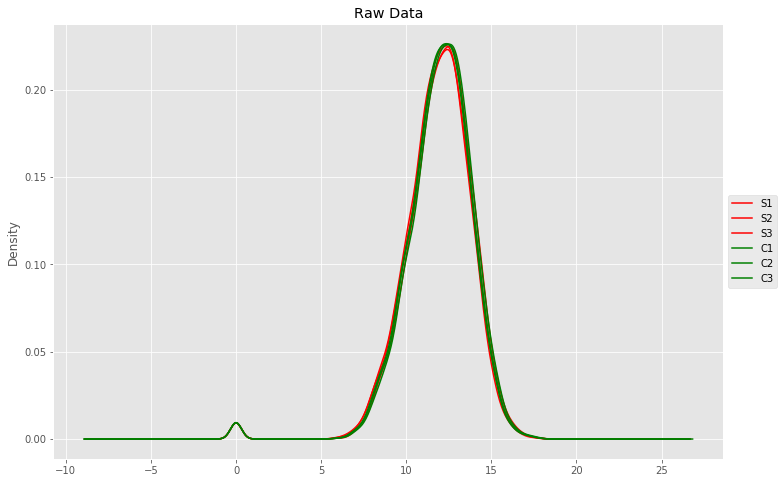

In [34]:
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw Data')
plt.show()

Tee pictures above show a very good distribution of the TMT channel intensity for bot senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### PCA analysis


[0.96589526 0.03215583]


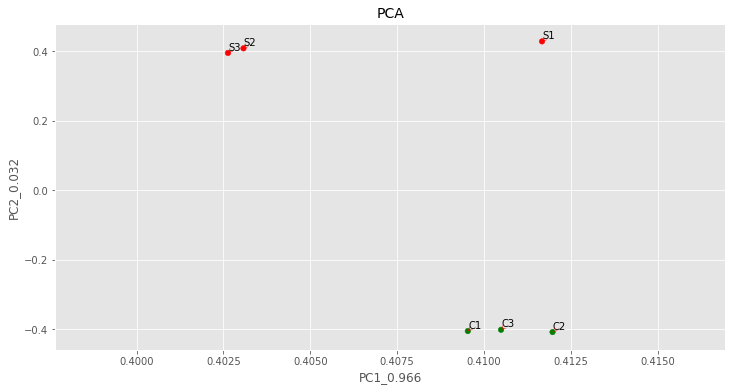

In [35]:
make_pca(np.log2(data), my_pal)

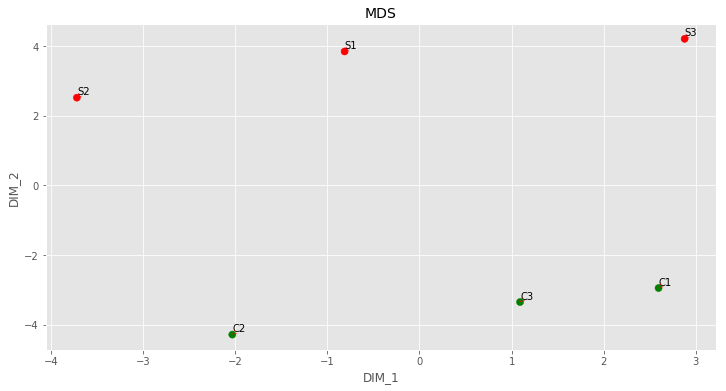

In [36]:
make_mds(np.log2(data), my_pal)

With two dimensinality reduction tecniques (PCA and MDS) we observe a good separation of senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### Reproducibility analysis

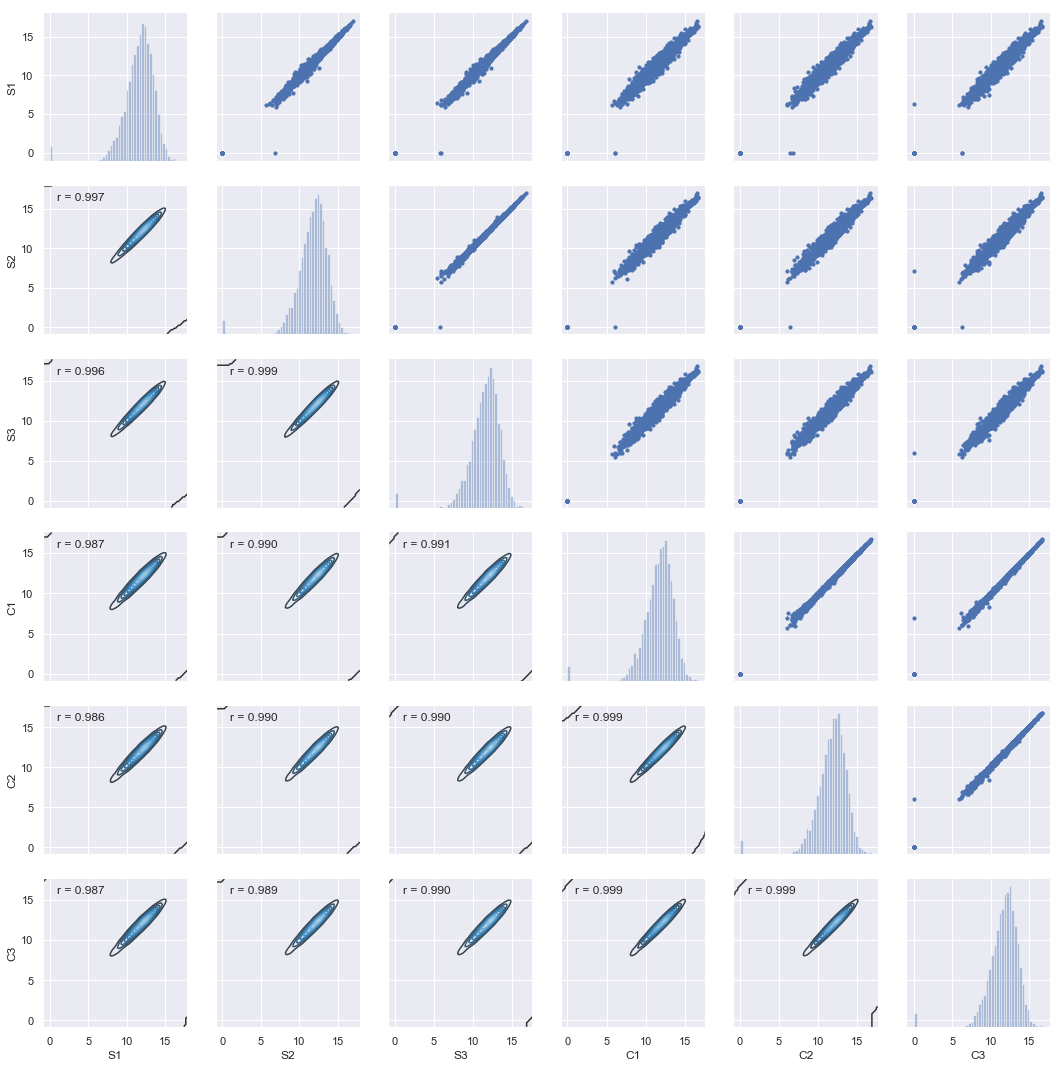

In [24]:
make_scatter_matrix(np.log1p(data))

The figure above show a very good intraclass correlation  between the senescent samples (S1,S2,S3) and the control samples (C1 C2 C3). As expected, the correletion decrese between samples of different classes.

### Data Normalization
We do a correction for sample loading artefact. We do not expect the signal to change much.

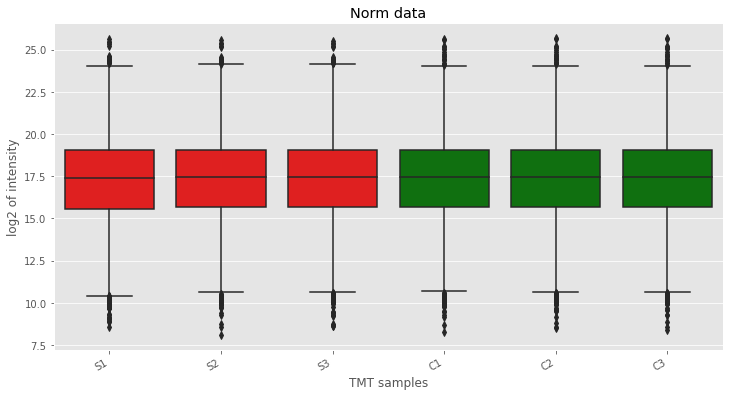

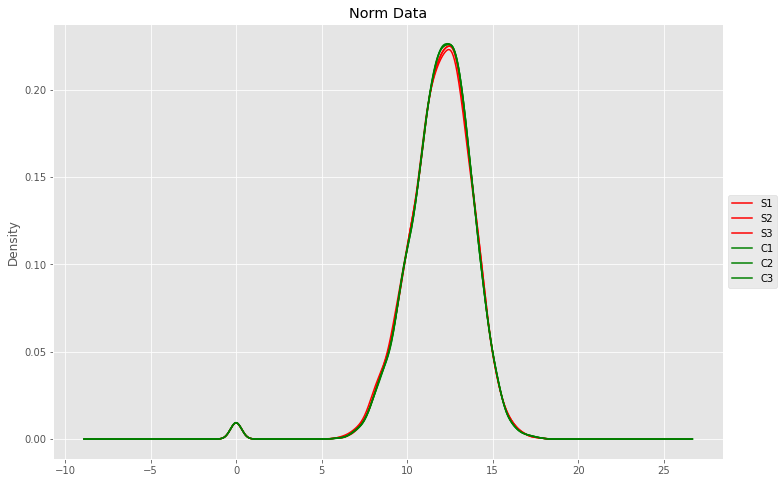

In [37]:
#normalization
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data_norm),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Norm data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data_norm).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm Data')
plt.show()

In [38]:
df['Gene names']=['_'.join(n.split(';')[0].split(' ')[0].split('|')[1:]) for n in df['Fasta headers']]

In [39]:
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.to_csv(TXT_PATH+'norm_data_maxquant16660_4x.csv',sep='\t',index=False)

In [40]:
#df.head()

In [41]:
data_norm.head(6)

,S1,S2,S3,C1,C2,C3,genes
92,4.550105e+05,6.091479e+05,6.313714e+05,560176.485087,575656.011794,570115.957651,92_ENST00000373020_O43657__TSPAN6
93,1.015777e+06,1.075491e+06,1.105387e+06,985332.735548,996475.723130,996778.340388,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
94,5.617969e+04,6.360398e+04,6.522373e+04,55064.317459,54436.278054,53118.815181,94_ENST00000423670__X6RHX1_SCYL3
95,4.817428e+05,5.171751e+05,5.284606e+05,681915.180304,699171.916740,674090.483338,95_ENST00000002165_Q9BTY2__FUCA2
96,9.814432e+05,9.939892e+05,9.566680e+05,812137.261957,794835.397111,791294.850351,96_ENST00000650454_P48506_Q14TF0_GCLC
98,4.758556e+05,4.775567e+05,4.797472e+05,420599.580024,412407.844486,413733.219623,98_ENST00000374807_Q9Y4W2__LAS1L


### Testing for differences.
We use limma package in R to identify protein with a differential expression between normal and senescent cells.

In [143]:
#%load_ext rpy2.ipython

In [29]:
#%R require(ggplot2); require(tidyr)
#%R X=c(1,4,5,7); sd(X); mean(X)

array([4.25])

In [1]:
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 
limma_data <- read_tsv('D:\\michele\\old_age\\raw_4x\\combined\\txt\\norm_data_maxquant16660_4x.csv')
accession <- limma_data$'genes'
limma_data = within(limma_data, rm('genes'))


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'scales'

The following objects are masked from 'package:psych':

    alpha, rescale

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col

In [2]:
head(accession)
head(limma_data)

[1] "92_ENST00000373020_O43657__TSPAN6"        
[2] "93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1"
[3] "94_ENST00000423670__X6RHX1_SCYL3"         
[4] "95_ENST00000002165_Q9BTY2__FUCA2"         
[5] "96_ENST00000650454_P48506_Q14TF0_GCLC"    
[6] "98_ENST00000374807_Q9Y4W2__LAS1L"

S1,S2,S3,C1,C2,C3
455010.49,609147.91,631371.40,560176.49,575656.01,570115.96
1015776.87,1075491.10,1105386.97,985332.74,996475.72,996778.34
56179.69,63603.98,65223.73,55064.32,54436.28,53118.82
481742.81,517175.13,528460.64,681915.18,699171.92,674090.48
981443.19,993989.18,956668.03,812137.26,794835.40,791294.85
475855.57,477556.66,479747.22,420599.58,412407.84,413733.22


In [3]:
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")
design
# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)
contrast


senescent,control
1,0
1,0
1,0
0,1
0,1
0,1


,senescent - control
senescent,1
control,-1


In [4]:
group

[1] senescent senescent senescent control   control   control  
Levels: senescent control

In [5]:
S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)


       senescent - control
Down                  2807
NotSig                2624
Up                    2995

,logFC,AveExpr,t,P.Value,adj.P.Val,B
2674,1.534932,19.90321,72.11081,7.507522e-11,2.166821e-07,15.68483
2209,1.330712,21.00735,70.61069,8.629324e-11,2.166821e-07,15.57403
5574,1.760697,18.54196,70.14208,9.018457e-11,2.166821e-07,15.53864
1168,1.730161,20.78309,68.76287,1.028636e-10,2.166821e-07,15.43225
8419,-1.988403,18.93743,-64.62300,1.551923e-10,2.205393e-07,15.09171
4343,-1.095674,21.25520,-63.90319,1.671422e-10,2.205393e-07,15.02905
1537,1.348866,18.67800,62.01647,2.038344e-10,2.205393e-07,14.85958
2740,1.103643,20.39205,61.76517,2.093893e-10,2.205393e-07,14.83642
5593,1.090194,20.26248,57.88530,3.217418e-10,2.676570e-07,14.46018
5694,-1.363603,19.71800,-57.49521,3.364719e-10,2.676570e-07,14.42031


In [6]:
limma_data$ave_med <- rowMeans(limma_data[S])
limma_data$ave_exo  <- rowMeans(limma_data[C])
limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          (limma_data$ave_exo / limma_data$ave_med), 
                          (-1 * limma_data$ave_med / limma_data$ave_exo))
limma_data$Acc <- accession
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc
455010.49,609147.91,631371.40,560176.49,575656.01,570115.96,565176.60,568649.48,0.008837914,1.006145,92_ENST00000373020_O43657__TSPAN6
1015776.87,1075491.10,1105386.97,985332.74,996475.72,996778.34,1065551.65,992862.27,-0.101935020,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
56179.69,63603.98,65223.73,55064.32,54436.28,53118.82,61669.13,54206.47,-0.186083541,-1.137671,94_ENST00000423670__X6RHX1_SCYL3
481742.81,517175.13,528460.64,681915.18,699171.92,674090.48,509126.19,685059.19,0.428205359,1.345559,95_ENST00000002165_Q9BTY2__FUCA2
981443.19,993989.18,956668.03,812137.26,794835.40,791294.85,977366.80,799422.50,-0.289941920,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC
475855.57,477556.66,479747.22,420599.58,412407.84,413733.22,477719.82,415580.21,-0.201037765,-1.149525,98_ENST00000374807_Q9Y4W2__LAS1L


In [7]:
# statisticl test results
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR
455010.49,609147.91,631371.40,560176.49,575656.01,570115.96,565176.60,568649.48,0.008837914,1.006145,92_ENST00000373020_O43657__TSPAN6,8.467112e-01,8.742052e-01
1015776.87,1075491.10,1105386.97,985332.74,996475.72,996778.34,1065551.65,992862.27,-0.101935020,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.869454e-02,3.223807e-02
56179.69,63603.98,65223.73,55064.32,54436.28,53118.82,61669.13,54206.47,-0.186083541,-1.137671,94_ENST00000423670__X6RHX1_SCYL3,2.378770e-02,3.972159e-02
481742.81,517175.13,528460.64,681915.18,699171.92,674090.48,509126.19,685059.19,0.428205359,1.345559,95_ENST00000002165_Q9BTY2__FUCA2,1.462152e-05,9.400859e-05
981443.19,993989.18,956668.03,812137.26,794835.40,791294.85,977366.80,799422.50,-0.289941920,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC,6.853123e-06,5.570824e-05
475855.57,477556.66,479747.22,420599.58,412407.84,413733.22,477719.82,415580.21,-0.201037765,-1.149525,98_ENST00000374807_Q9Y4W2__LAS1L,3.570986e-05,1.852779e-04


In [8]:
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [9]:
# count candidates
print("Candidate Counts:")
summary(limma_data$candidate)

[1] "Candidate Counts:"


high  med  low   no NA's 
4065 1161  576 2624   65

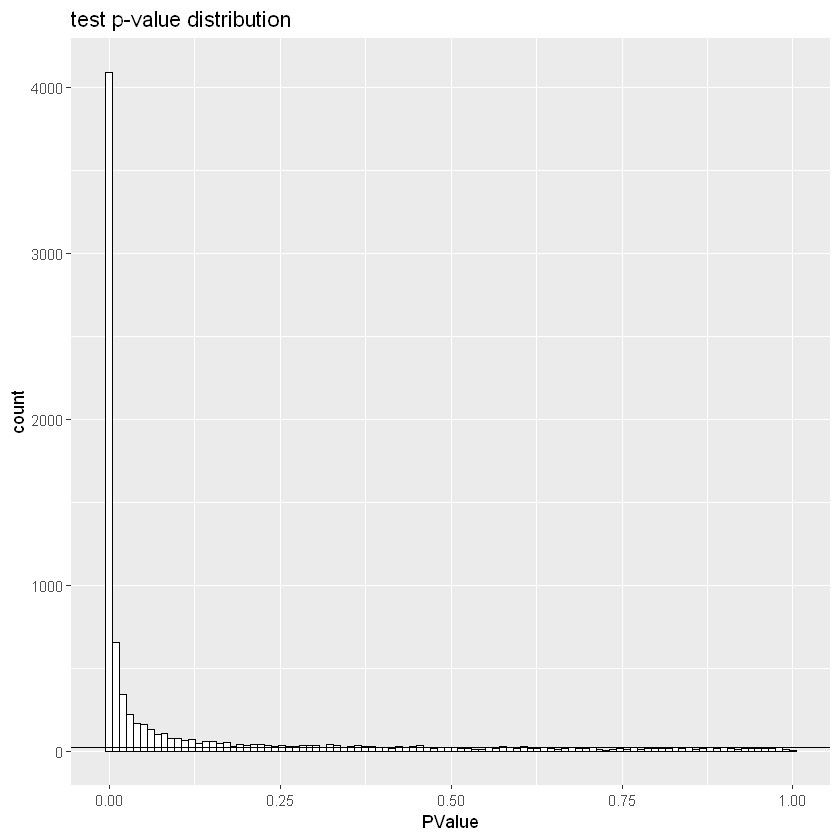

In [10]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

pvalue_plot(limma_data, "test")

The figure above show the expected distribution of p-value, our test is safe

In [11]:
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
455010.49,609147.91,631371.40,560176.49,575656.01,570115.96,565176.60,568649.48,0.008837914,1.006145,92_ENST00000373020_O43657__TSPAN6,8.467112e-01,8.742052e-01,no
1015776.87,1075491.10,1105386.97,985332.74,996475.72,996778.34,1065551.65,992862.27,-0.101935020,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.869454e-02,3.223807e-02,med
56179.69,63603.98,65223.73,55064.32,54436.28,53118.82,61669.13,54206.47,-0.186083541,-1.137671,94_ENST00000423670__X6RHX1_SCYL3,2.378770e-02,3.972159e-02,med
481742.81,517175.13,528460.64,681915.18,699171.92,674090.48,509126.19,685059.19,0.428205359,1.345559,95_ENST00000002165_Q9BTY2__FUCA2,1.462152e-05,9.400859e-05,high
981443.19,993989.18,956668.03,812137.26,794835.40,791294.85,977366.80,799422.50,-0.289941920,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC,6.853123e-06,5.570824e-05,high
475855.57,477556.66,479747.22,420599.58,412407.84,413733.22,477719.82,415580.21,-0.201037765,-1.149525,98_ENST00000374807_Q9Y4W2__LAS1L,3.570986e-05,1.852779e-04,high


In [12]:
write.table(limma_data,'D:\\michele\\old_age\\raw_4x\\combined\\txt\\limma_data_maxquant16660_4x.txt')
#data_norm = pd.read_csv('norm_data.csv',sep='\t')
#print(data_norm.shape)
#data_norm.head()
#del data_norm['gene_names']

## Restart python  Kernel

In [42]:
print(data_norm.shape)
data_norm.head()

(8491, 7)


,S1,S2,S3,C1,C2,C3,genes
92,4.550105e+05,6.091479e+05,6.313714e+05,560176.485087,575656.011794,570115.957651,92_ENST00000373020_O43657__TSPAN6
93,1.015777e+06,1.075491e+06,1.105387e+06,985332.735548,996475.723130,996778.340388,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
94,5.617969e+04,6.360398e+04,6.522373e+04,55064.317459,54436.278054,53118.815181,94_ENST00000423670__X6RHX1_SCYL3
95,4.817428e+05,5.171751e+05,5.284606e+05,681915.180304,699171.916740,674090.483338,95_ENST00000002165_Q9BTY2__FUCA2
96,9.814432e+05,9.939892e+05,9.566680e+05,812137.261957,794835.397111,791294.850351,96_ENST00000650454_P48506_Q14TF0_GCLC


In [43]:
#we load back the R analysis
r_analysis = pd.read_table(TXT_PATH+'limma_data_maxquant16660_4x.txt',sep=' ')
print(r_analysis.shape)
r_analysis = r_analysis.reset_index(drop=True)
r_analysis.head()

(8491, 14)


,S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
0,4.550105e+05,6.091479e+05,6.313714e+05,560176.485087,575656.011794,570115.957651,5.651766e+05,568649.484844,0.008838,1.006145,92_ENST00000373020_O43657__TSPAN6,0.846711,0.874205,no
1,1.015777e+06,1.075491e+06,1.105387e+06,985332.735548,996475.723130,996778.340388,1.065552e+06,992862.266355,-0.101935,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018695,0.032238,med
2,5.617969e+04,6.360398e+04,6.522373e+04,55064.317459,54436.278054,53118.815181,6.166913e+04,54206.470231,-0.186084,-1.137671,94_ENST00000423670__X6RHX1_SCYL3,0.023788,0.039722,med
3,4.817428e+05,5.171751e+05,5.284606e+05,681915.180304,699171.916740,674090.483338,5.091262e+05,685059.193461,0.428205,1.345559,95_ENST00000002165_Q9BTY2__FUCA2,0.000015,0.000094,high
4,9.814432e+05,9.939892e+05,9.566680e+05,812137.261957,794835.397111,791294.850351,9.773668e+05,799422.503140,-0.289942,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000056,high


In [44]:
data_def = data_norm.merge(r_analysis.iloc[:,6:],left_on='genes',right_on='Acc' )
data_def.shape

(8491, 15)

In [45]:
#top 50 proteins
data_def.sort_values('FDR').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
5573,7.068452e+05,7.104219e+05,6.906360e+05,2.112027e+05,2.071728e+05,2.036995e+05,6088_ENST00000290271_P52823__STC1,7.026344e+05,2.073583e+05,-1.760648,-3.388503,6088_ENST00000290271_P52823__STC1,9.018457e-11,2.166821e-07,high
2673,1.654649e+06,1.683507e+06,1.669386e+06,5.845032e+05,5.639482e+05,5.797878e+05,2955_ENST00000409512_Q16719__KYNU,1.669180e+06,5.760797e+05,-1.534799,-2.897482,2955_ENST00000409512_Q16719__KYNU,7.507522e-11,2.166821e-07,high
1167,3.304910e+06,3.342971e+06,3.213329e+06,1.017586e+06,9.741105e+05,9.807923e+05,1357_ENST00000443427_P03372_G4XH65_ESR1,3.287070e+06,9.908297e+05,-1.730093,-3.317492,1357_ENST00000443427_P03372_G4XH65_ESR1,1.028636e-10,2.166821e-07,high
2208,3.388882e+06,3.282633e+06,3.358366e+06,1.318285e+06,1.337025e+06,1.332004e+06,2462_ENST00000456829_O00534_A0A024R3H3_VWA5A,3.343294e+06,1.329105e+06,-1.330815,-2.515448,2462_ENST00000456829_O00534_A0A024R3H3_VWA5A,8.629324e-11,2.166821e-07,high
4342,1.687401e+06,1.716089e+06,1.733234e+06,3.661085e+06,3.644358e+06,3.671782e+06,4752_ENST00000354960_O76074__PDE5A,1.712241e+06,3.659075e+06,1.095593,2.137009,4752_ENST00000354960_O76074__PDE5A,1.671422e-10,2.205393e-07,high
2739,2.046246e+06,2.008493e+06,1.996957e+06,9.397765e+05,9.351750e+05,9.410025e+05,3024_ENST00000354777_Q5T9L3__WLS,2.017232e+06,9.386514e+05,-1.103716,-2.149075,3024_ENST00000354777_Q5T9L3__WLS,2.093893e-10,2.205393e-07,high
1536,6.624104e+05,6.767629e+05,6.690044e+05,2.658198e+05,2.606683e+05,2.619208e+05,1746_ENST00000261596_Q92539__LPIN2,6.693926e+05,2.628029e+05,-1.348871,-2.547127,1746_ENST00000261596_Q92539__LPIN2,2.038344e-10,2.205393e-07,high
8418,2.436824e+05,2.512821e+05,2.614377e+05,9.886085e+05,9.970190e+05,1.014689e+06,9251_ENST00000585132_Q13772_A0A024QZI5_NCOA4,2.521341e+05,1.000105e+06,1.987889,3.966562,9251_ENST00000585132_Q13772_A0A024QZI5_NCOA4,1.551923e-10,2.205393e-07,high
7852,2.508654e+06,2.527116e+06,2.391642e+06,8.911126e+05,8.589249e+05,8.696215e+05,8612_ENST00000457692_P05120__SERPINB2,2.475804e+06,8.732197e+05,-1.503481,-2.835259,8612_ENST00000457692_P05120__SERPINB2,4.849791e-10,2.676570e-07,high
5592,1.812288e+06,1.854308e+06,1.839534e+06,8.641295e+05,8.523331e+05,8.697318e+05,6108_ENST00000409174__E9PB90_HK2,1.835376e+06,8.620648e+05,-1.090208,-2.129047,6108_ENST00000409174__E9PB90_HK2,3.217418e-10,2.676570e-07,high


The top 20 protein by FDR are all under represented in senescent cell

## Visualize differential expression

In [46]:
data_def['log10p']=-np.log10(data_def['PValue'])

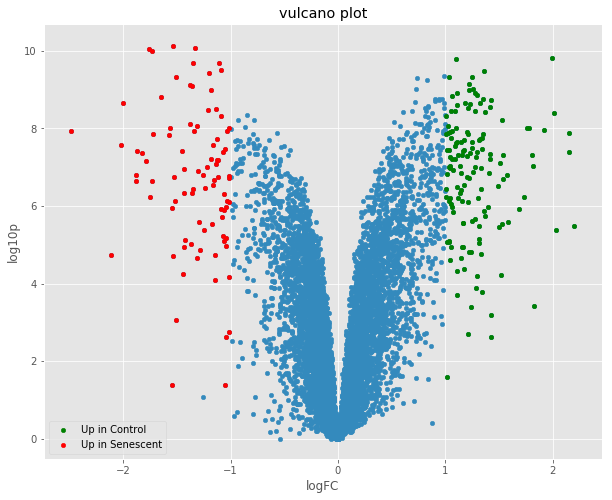

In [47]:
fig,ax=plt.subplots(figsize=(10,8))

data_def.plot(kind='scatter',x='logFC',y='log10p',ax=ax)

data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='g', label='Up in Control')

data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='r', label='Up in Senescent')
plt.legend()
plt.title('vulcano plot')
plt.show()

## Interactive Vulcano Plot


In [48]:
up_control = data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)]
up_senescent = data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)]
the_rest = data_def.iloc[~data_def.index.isin( list(up_control.index.values) + list(up_senescent.index.values) ) ]
#the_rest = the_rest.iloc[~up_senescent.index.values]

In [49]:
data_def.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
0,4.550105e+05,6.091479e+05,6.313714e+05,560176.485087,575656.011794,570115.957651,92_ENST00000373020_O43657__TSPAN6,5.651766e+05,568649.484844,0.008838,1.006145,92_ENST00000373020_O43657__TSPAN6,0.846711,0.874205,no,0.072265
1,1.015777e+06,1.075491e+06,1.105387e+06,985332.735548,996475.723130,996778.340388,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.065552e+06,992862.266355,-0.101935,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018695,0.032238,med,1.728285
2,5.617969e+04,6.360398e+04,6.522373e+04,55064.317459,54436.278054,53118.815181,94_ENST00000423670__X6RHX1_SCYL3,6.166913e+04,54206.470231,-0.186084,-1.137671,94_ENST00000423670__X6RHX1_SCYL3,0.023788,0.039722,med,1.623648
3,4.817428e+05,5.171751e+05,5.284606e+05,681915.180304,699171.916740,674090.483338,95_ENST00000002165_Q9BTY2__FUCA2,5.091262e+05,685059.193461,0.428205,1.345559,95_ENST00000002165_Q9BTY2__FUCA2,0.000015,0.000094,high,4.835007
4,9.814432e+05,9.939892e+05,9.566680e+05,812137.261957,794835.397111,791294.850351,96_ENST00000650454_P48506_Q14TF0_GCLC,9.773668e+05,799422.503140,-0.289942,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000056,high,5.164111


In [50]:
print(up_senescent.shape)
up_senescent.sort_values('logFC').head(10)

(89, 16)


,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
5482,8.272733e+04,9.655842e+04,9.525466e+04,17178.857535,16353.791945,15635.267021,5986_ENST00000652588___NRG1,9.151347e+04,16389.305500,-2.481229,-5.583731,5986_ENST00000652588___NRG1,1.157776e-08,1.014122e-06,high,7.936375
3246,1.336514e+06,8.261584e+05,8.018346e+05,221754.461550,221877.702132,243950.255950,3567_ENST00000245185_P02795__MT2A,9.881689e+05,229194.139877,-2.108187,-4.311493,3567_ENST00000245185_P02795__MT2A,1.782080e-05,1.087314e-04,high,4.749073
3148,3.955974e+04,3.747324e+04,4.298064e+04,10257.443128,9556.387807,9781.663591,3461_ENST00000243347_P98066__TNFAIP6,4.000454e+04,9865.164842,-2.019749,-4.055132,3461_ENST00000243347_P98066__TNFAIP6,2.721203e-08,1.500598e-06,high,7.565239
3275,1.095719e+06,1.226520e+06,1.180675e+06,295406.634637,298435.650692,280873.540376,3599_ENST00000263341_P01584__IL1B,1.167638e+06,291571.941902,-2.001669,-4.004631,3599_ENST00000263341_P01584__IL1B,2.248756e-09,4.621468e-07,high,8.648058
6547,2.224802e+05,1.986493e+05,1.761498e+05,54252.726157,52576.431498,55646.516683,7137_ENST00000401931__C9J4T6_CXCL8,1.990931e+05,54158.558113,-1.878182,-3.676115,7137_ENST00000401931__C9J4T6_CXCL8,1.581165e-07,3.895584e-06,high,6.801023
755,2.080121e+06,2.683065e+06,2.517310e+06,666061.326938,651145.499334,664829.594411,906_ENST00000367468_P35354__PTGS2,2.426832e+06,660678.806894,-1.877053,-3.673241,906_ENST00000367468_P35354__PTGS2,2.311368e-07,4.980970e-06,high,6.636131
2142,3.178084e+05,3.727274e+05,3.757329e+05,98093.355372,95473.330529,98423.003634,2386_ENST00000620436__A0A087WX92_SLC16A6,3.554229e+05,97329.896512,-1.868582,-3.651734,2386_ENST00000620436__A0A087WX92_SLC16A6,3.867053e-08,1.759518e-06,high,7.412620
5917,3.658348e+05,4.417627e+05,4.015648e+05,112593.856619,113338.360985,115400.297741,6452_ENST00000296027_P42830_Q6I9S7_CXCL5,4.030541e+05,113777.505115,-1.824758,-3.542476,6452_ENST00000296027_P42830_Q6I9S7_CXCL5,4.191705e-08,1.834503e-06,high,7.377609
1408,1.596592e+04,1.656958e+04,1.763750e+04,4736.417437,5026.656365,4779.981761,1610_ENST00000556532__H0YIZ5_PLEK2,1.672434e+04,4847.685188,-1.786581,-3.449963,1610_ENST00000556532__H0YIZ5_PLEK2,7.062552e-08,2.438577e-06,high,7.151038
5573,7.068452e+05,7.104219e+05,6.906360e+05,211202.724707,207172.780965,203699.465979,6088_ENST00000290271_P52823__STC1,7.026344e+05,207358.323884,-1.760648,-3.388503,6088_ENST00000290271_P52823__STC1,9.018457e-11,2.166821e-07,high,10.044868


In [72]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
#interactive plot 'logFC',y='log10p'
trace_1 = go.Scatter(
    x=the_rest.logFC,
    y=the_rest.log10p,
    mode='markers',
    name='MA Plot',
    #text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    #hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'blue'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_2 = go.Scatter(
    x=up_control.logFC,
    y=up_control.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_3 = go.Scatter(
    x=up_senescent.logFC,
    y=up_senescent.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

'''

annot_1 = go.Scatter(
    x=[temp.signal_perc.loc['Tb927.3.2610']],
    y=[temp.signal_logfc.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)
'''

layout = dict(title='Vulcano',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_1,trace_2,trace_3], 
                layout=layout)
#iplot(fig, filename='test')

In [52]:
#attach the old index so we can grab other columns from the MaxQuont ProteinGroup file
data_def['index']=[int(n.split('_')[0]) for n in data_def['genes']]
data_def.head()
data_def.set_index('index',inplace=True,drop=True)

In [54]:
df.head()
#write proteins for go enrichemnt analysis
#data_def[data_def['logFC']<-1].sort_values('PValue').to_csv('up_senescent.csv')

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Best MS/MS,Deamidation (NQ) site IDs,Formyl site IDs,Oxidation (M) site IDs,TMT6plex-ST-var site IDs,Deamidation (NQ) site positions,Formyl site positions,Oxidation (M) site positions,TMT6plex-ST-var site positions,Gene names
92,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,6;4;2,6;4;2,6;4;2,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,3,6,6,6,...,28267;41142;117813;167974;280427;284358,36,7250;7251;7252,NaN,276;277;24509;24510;24511,54,45;51;169,NaN,51;150;157;165;169,ENST00000373020_O43657__TSPAN6
93,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,14;14;14;7,14;14;14;7,14;14;14;7,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,4,14,14,14,...,39951;46296;63003;74561;74567;83818;85382;9391...,37;38,89;90;91;7253;7254;7255;7256,65,278;279;280;24512;24513;24514,151;244,181;184;186;223;230;248;260,106,28;33;110;122;223;230,ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
94,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,7;7;7;7,7;7;7;7,7;7;7;7,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,4,7,7,7,...,27456;52460;58239;187980;222660;273465;273796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000423670__X6RHX1_SCYL3
95,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2;...,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2,12;2,12;2,12;2,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2,2,12,12,12,...,9508;42185;60503;90526;95288;209558;210428;292...,39,7257,NaN,281;282;24515;24516,113,124,NaN,276;311;404;405,ENST00000002165_Q9BTY2__FUCA2
96,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,19;19;16;16;15;10;3,18;18;15;15;14;9;3,9;9;6;6;5;9;3,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,7,19,18,9,...,27559;29016;37486;43066;45054;63608;79213;8377...,NaN,7258;7259;7260;7261,66;67;68,283;284;285,NaN,5;172;464;554,54;483;597,57;331;334,ENST00000650454_P48506_Q14TF0_GCLC


### Visualize some top candidates


In [55]:
value_cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]

def plot_data(ax='', 
              ids=[], 
              dataframe=pd.DataFrame(), 
              title='',
              typeOfPlot = 'swarm'):
    temp = dataframe[dataframe['id'].isin(ids)][value_cols]
    temp.columns=['S1','S2','S3','C1','C2','C3']
    temp=temp.replace(0,np.nan)
    temp = temp.dropna(thresh=1,axis=1)
    if typeOfPlot == 'swarm':
        sns.swarmplot(data=temp,ax=ax)#, color)
    if typeOfPlot == 'box':
        sns.boxplot(data=temp,ax=ax, showfliers=False)#, color)
    
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    ax.set_title(title)
    
def plot_prot(ax = '', 
              prot_id = 2742, 
              dataframe=pd.DataFrame()):
    temp = dataframe.loc[prot_id][value_cols]
    #print(temp.head())
    temp.plot(kind='bar', ax=ax, colors=my_pal)
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    ax.set_xticklabels(['S1','S2','S3','C1','C2','C3'],rotation=-360)
    ax.set_title(df.loc[prot_id]['Gene names'])
    
def make_plot(prot_id= 5064, typeOfPlot='swarm'):
    gridsize = (2, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (1, 1), colspan=1, rowspan=1)
    ax3 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)
    plot_prot(ax1, prot_id = prot_id, dataframe=df)
    ids = df.loc[prot_id]['Peptide IDs'].split(';')
    ids=[int(n) for n in ids]
    plot_data(ax2, ids = ids, dataframe=peptides,
              title ='Peptides', typeOfPlot=typeOfPlot)
    ids = df.loc[prot_id]['Evidence IDs'].split(';')
    ids=[int(n) for n in ids]
    plot_data(ax3, ids = ids, dataframe=evi,
              title ='Evidences', typeOfPlot=typeOfPlot)
    plt.tight_layout()
    plt.show()
    
#data_def[data_def['logFC']<-1].sort_values('PValue').head()

In [56]:
peptides = pd.read_table(os.path.join('raw_4x', 'combined', 'txt', 'peptides.txt'))
evi =  pd.read_table(os.path.join('raw_4x', 'combined', 'txt', 'evidence.txt'))
#peptides['Protein group IDs'].head(),evi['Protein group IDs'].head()

In [57]:
peptides['id']=peptides['id'].astype(int)
evi['id'] = evi['id'].astype(int)

In [58]:
up_senescent.sort_values('FC').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
5482,8.272733e+04,9.655842e+04,9.525466e+04,17178.857535,16353.791945,15635.267021,5986_ENST00000652588___NRG1,9.151347e+04,16389.305500,-2.481229,-5.583731,5986_ENST00000652588___NRG1,1.157776e-08,1.014122e-06,high,7.936375
3246,1.336514e+06,8.261584e+05,8.018346e+05,221754.461550,221877.702132,243950.255950,3567_ENST00000245185_P02795__MT2A,9.881689e+05,229194.139877,-2.108187,-4.311493,3567_ENST00000245185_P02795__MT2A,1.782080e-05,1.087314e-04,high,4.749073
3148,3.955974e+04,3.747324e+04,4.298064e+04,10257.443128,9556.387807,9781.663591,3461_ENST00000243347_P98066__TNFAIP6,4.000454e+04,9865.164842,-2.019749,-4.055132,3461_ENST00000243347_P98066__TNFAIP6,2.721203e-08,1.500598e-06,high,7.565239
3275,1.095719e+06,1.226520e+06,1.180675e+06,295406.634637,298435.650692,280873.540376,3599_ENST00000263341_P01584__IL1B,1.167638e+06,291571.941902,-2.001669,-4.004631,3599_ENST00000263341_P01584__IL1B,2.248756e-09,4.621468e-07,high,8.648058
6547,2.224802e+05,1.986493e+05,1.761498e+05,54252.726157,52576.431498,55646.516683,7137_ENST00000401931__C9J4T6_CXCL8,1.990931e+05,54158.558113,-1.878182,-3.676115,7137_ENST00000401931__C9J4T6_CXCL8,1.581165e-07,3.895584e-06,high,6.801023
755,2.080121e+06,2.683065e+06,2.517310e+06,666061.326938,651145.499334,664829.594411,906_ENST00000367468_P35354__PTGS2,2.426832e+06,660678.806894,-1.877053,-3.673241,906_ENST00000367468_P35354__PTGS2,2.311368e-07,4.980970e-06,high,6.636131
2142,3.178084e+05,3.727274e+05,3.757329e+05,98093.355372,95473.330529,98423.003634,2386_ENST00000620436__A0A087WX92_SLC16A6,3.554229e+05,97329.896512,-1.868582,-3.651734,2386_ENST00000620436__A0A087WX92_SLC16A6,3.867053e-08,1.759518e-06,high,7.412620
5917,3.658348e+05,4.417627e+05,4.015648e+05,112593.856619,113338.360985,115400.297741,6452_ENST00000296027_P42830_Q6I9S7_CXCL5,4.030541e+05,113777.505115,-1.824758,-3.542476,6452_ENST00000296027_P42830_Q6I9S7_CXCL5,4.191705e-08,1.834503e-06,high,7.377609
1408,1.596592e+04,1.656958e+04,1.763750e+04,4736.417437,5026.656365,4779.981761,1610_ENST00000556532__H0YIZ5_PLEK2,1.672434e+04,4847.685188,-1.786581,-3.449963,1610_ENST00000556532__H0YIZ5_PLEK2,7.062552e-08,2.438577e-06,high,7.151038
5573,7.068452e+05,7.104219e+05,6.906360e+05,211202.724707,207172.780965,203699.465979,6088_ENST00000290271_P52823__STC1,7.026344e+05,207358.323884,-1.760648,-3.388503,6088_ENST00000290271_P52823__STC1,9.018457e-11,2.166821e-07,high,10.044868


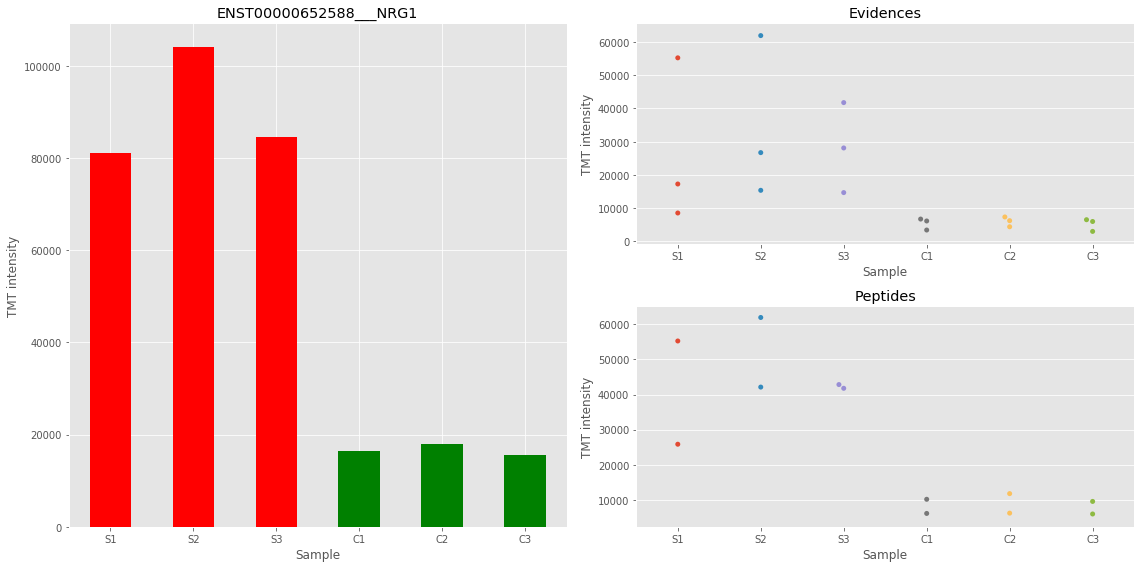

In [62]:
make_plot(prot_id= 5986, typeOfPlot='swarm')

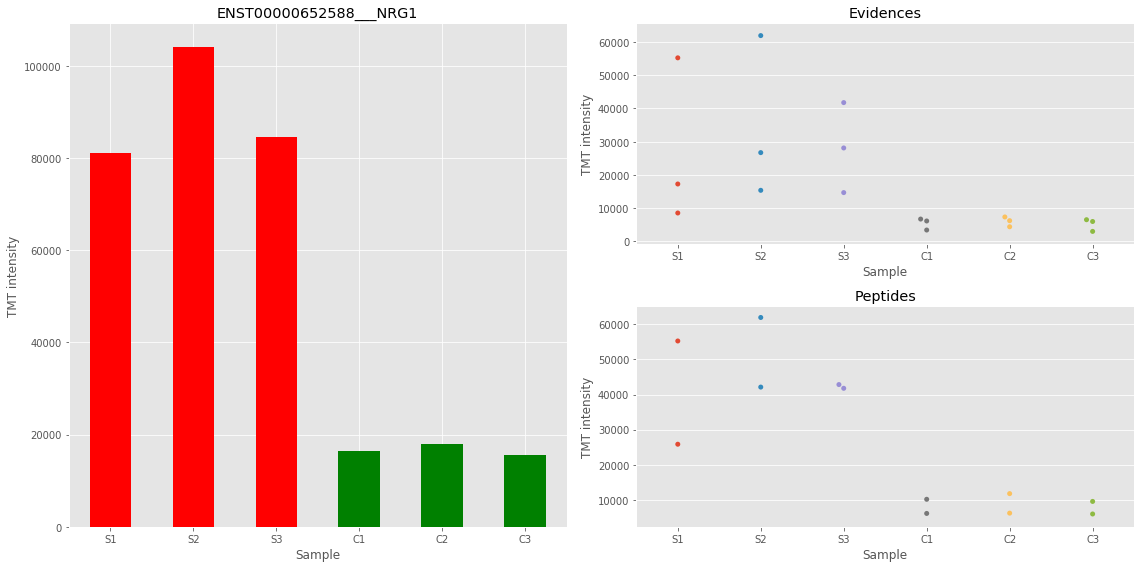

In [63]:
make_plot(prot_id= 5986)

In [211]:
peptides['Proteins'].str.contains('__').value_counts()

False    89314
True      1023
Name: Proteins, dtype: int64

In [237]:
peptides['Proteins'][~peptides['Proteins'].isin(df['Protein IDs'])].head()
#tag = df['Only identified by site'].astype(str)+df['Reverse'].astype(str)+df['Potential contaminant'].astype(str)
#tag.head()

0    ENSG00000064651|ENST00000343225|P55011||SLC12A...
1    ENSG00000049618|ENST00000346085|||ARID1B;ENSG0...
2       ENSG00000109132|ENST00000226382|Q99453||PHOX2B
3    ENSG00000186660|ENST00000316059|Q96JP5|A0A024R...
4    ENSG00000167258|ENST00000430627|Q9NYV4||CDK12;...
Name: Proteins, dtype: object

In [298]:
peptides['id'].head()

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int32

In [247]:
#%%time
to_find = []
for n in df['Peptide IDs']:
    for m in n.split(';'):
        to_find.append(int(m))
to_find = list(set(to_find))        
peptides.loc[to_find].shape

(88626, 99)

In [297]:
peptides['Protein group IDs'].head()
#prot_name = pd.Series([n.split('|')[2] for n in peptides['Proteins']])
#prot_name.head()

0          649
1          492
2         2405
3         8296
4    6894;3849
Name: Protein group IDs, dtype: object

In [271]:
data_def.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
index,,,,,,,,,,,,,,,,
92,4.550105e+05,6.091479e+05,6.313714e+05,560176.485087,575656.011794,570115.957651,92_ENST00000373020_O43657__TSPAN6,5.651766e+05,568649.484844,0.008838,1.006145,92_ENST00000373020_O43657__TSPAN6,0.846711,0.874205,no,0.072265
93,1.015777e+06,1.075491e+06,1.105387e+06,985332.735548,996475.723130,996778.340388,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.065552e+06,992862.266355,-0.101935,-1.073212,93_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.018695,0.032238,med,1.728285
94,5.617969e+04,6.360398e+04,6.522373e+04,55064.317459,54436.278054,53118.815181,94_ENST00000423670__X6RHX1_SCYL3,6.166913e+04,54206.470231,-0.186084,-1.137671,94_ENST00000423670__X6RHX1_SCYL3,0.023788,0.039722,med,1.623648
95,4.817428e+05,5.171751e+05,5.284606e+05,681915.180304,699171.916740,674090.483338,95_ENST00000002165_Q9BTY2__FUCA2,5.091262e+05,685059.193461,0.428205,1.345559,95_ENST00000002165_Q9BTY2__FUCA2,0.000015,0.000094,high,4.835007
96,9.814432e+05,9.939892e+05,9.566680e+05,812137.261957,794835.397111,791294.850351,96_ENST00000650454_P48506_Q14TF0_GCLC,9.773668e+05,799422.503140,-0.289942,-1.222591,96_ENST00000650454_P48506_Q14TF0_GCLC,0.000007,0.000056,high,5.164111


In [304]:
df['Mol. weight [kDa]'].head()

92    27.563
93    29.634
94    65.298
95    54.066
96    72.765
Name: Mol. weight [kDa], dtype: float64

In [307]:
print(data_def.shape,df.shape)

(8491, 17) (8491, 82)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,MS/MS IDs,Best MS/MS,Deamidation (NQ) site IDs,Formyl site IDs,Oxidation (M) site IDs,TMT6plex-ST-var site IDs,Deamidation (NQ) site positions,Formyl site positions,Oxidation (M) site positions,TMT6plex-ST-var site positions
92,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,6;4;2,6;4;2,6;4;2,ENSG00000000003|ENST00000373020|O43657||TSPAN6...,3,6,6,6,...,28266;28267;41137;41138;41139;41140;41141;4114...,28267;41142;117813;167974;280427;284358,36,7250;7251;7252,NaN,276;277;24509;24510;24511,54,45;51;169,NaN,51;150;157;165;169
93,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,14;14;14;7,14;14;14;7,14;14;14;7,ENSG00000000419|ENST00000371588|O60762|A0A0S2Z...,4,14,14,14,...,39950;39951;46296;46297;63003;63004;74560;7456...,39951;46296;63003;74561;74567;83818;85382;9391...,37;38,89;90;91;7253;7254;7255;7256,65,278;279;280;24512;24513;24514,151;244,181;184;186;223;230;248;260,106,28;33;110;122;223;230
94,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,7;7;7;7,7;7;7;7,7;7;7;7,ENSG00000000457|ENST00000423670||X6RHX1|SCYL3;...,4,7,7,7,...,27456;52460;52461;58239;187978;187979;187980;2...,27456;52460;58239;187980;222660;273465;273796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2;...,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2,12;2,12;2,12;2,ENSG00000001036|ENST00000002165|Q9BTY2||FUCA2,2,12,12,12,...,9508;9509;42185;42186;60501;60502;60503;60504;...,9508;42185;60503;90526;95288;209558;210428;292...,39,7257,NaN,281;282;24515;24516,113,124,NaN,276;311;404;405
96,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,19;19;16;16;15;10;3,18;18;15;15;14;9;3,9;9;6;6;5;9;3,ENSG00000001084|ENST00000650454|P48506|Q14TF0|...,7,19,18,9,...,27559;29013;29014;29015;29016;37486;37487;4306...,27559;29016;37486;43066;45054;63608;79213;8377...,NaN,7258;7259;7260;7261,66;67;68,283;284;285,NaN,5;172;464;554,54;483;597,57;331;334


6.022140857e+23

59
False    8474
True       17
dtype: int64


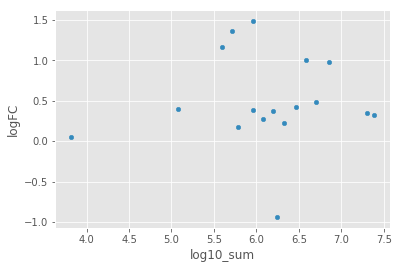

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p,log10_sum
index,,,,,,,,,,,,,,,,,
5588,1.093372e+06,1.178529e+06,1.197679e+06,5.952859e+05,6.152072e+05,5.980690e+05,5588_ENST00000541363__F5H2U8_HMGA2,1.156527e+06,6.028540e+05,-0.939918,-1.918419,5588_ENST00000541363__F5H2U8_HMGA2,8.247514e-08,0.000003,high,7.083677,6.245360
8565,3.401942e+03,2.771901e+03,3.534932e+03,2.823876e+03,3.328256e+03,3.941691e+03,8565_ENST00000369163_P68431__HIST1H3H,3.236258e+03,3.364608e+03,0.056112,1.039660,8565_ENST00000369163_P68431__HIST1H3H,7.578398e-01,0.798095,no,0.120423,3.819601
2148,3.299706e+05,2.581513e+05,2.587914e+05,3.268309e+05,3.100801e+05,3.213849e+05,2148_ENST00000296417_P0C0S5__H2AFZ,2.823044e+05,3.194319e+05,0.178257,1.131516,2148_ENST00000296417_P0C0S5__H2AFZ,9.163044e-02,0.127976,no,1.037960,5.779406
8376,9.733623e+05,9.592720e+05,9.637172e+05,1.113444e+06,1.154662e+06,1.108601e+06,8376_ENST00000530167_P16104__H2AFX,9.654505e+05,1.125569e+06,0.221380,1.165849,8376_ENST00000530167_P16104__H2AFX,3.300634e-05,0.000175,high,4.481403,6.320358
8417,4.648055e+05,5.609522e+05,6.104379e+05,7.022732e+05,6.230124e+05,6.526321e+05,8417_ENST00000340857_P07305__H1F0,5.453986e+05,6.593059e+05,0.273637,1.208852,8417_ENST00000340857_P07305__H1F0,2.762184e-02,0.045193,med,1.558747,6.080881
8811,1.045927e+07,1.105288e+07,1.121084e+07,1.369101e+07,1.367449e+07,1.366783e+07,8811_ENST00000545683_Q5QNW6__HIST2H2BF,1.090767e+07,1.367778e+07,0.326491,1.253960,8811_ENST00000545683_Q5QNW6__HIST2H2BF,8.887829e-06,0.000066,high,5.051204,7.390678
6046,8.018163e+06,9.008468e+06,9.242825e+06,1.125414e+07,1.121522e+07,1.095671e+07,6046_ENST00000377745_P62805_B2R4R0_HIST1H4B,8.756485e+06,1.114202e+07,0.347587,1.272431,6046_ENST00000377745_P62805_B2R4R0_HIST1H4B,3.226460e-04,0.001070,high,3.491274,7.298821
8061,6.746338e+05,6.773849e+05,7.231679e+05,9.111556e+05,8.873478e+05,8.887046e+05,8061_ENST00000403683_Q71DI3__HIST2H3A,6.917289e+05,8.957360e+05,0.372867,1.294924,8061_ENST00000403683_Q71DI3__HIST2H3A,1.154229e-05,0.000080,high,4.937708,6.200704
8156,3.548664e+05,3.993037e+05,4.181629e+05,5.571527e+05,4.695343e+05,5.028843e+05,8156_ENST00000333762_Q92522__H1FX,3.907777e+05,5.098571e+05,0.383745,1.304724,8156_ENST00000333762_Q92522__H1FX,2.365066e-03,0.005523,high,2.626157,5.954549


In [342]:
histones = []
for n in open('histone_all.fasta'):
    if n.startswith('>'):
        name = n.split('|')[1].split(' ')[0].split('_')[0]
        histones.append(name)
print(len(histones))
histones[0:2]
histones = set(histones)
prot_name = pd.Series([n.split('_')[2] for n in data_def['genes']])
is_histone = pd.Series([True if n in histones else False for n in prot_name ])
is_histone.loc[5117]=True
print(is_histone.value_counts())
data_def[is_histone.values]
data_def['log10_sum']=np.log10(data_def[['ave_med','ave_exo']].sum(axis=1))
data_def[is_histone.values].plot(kind='scatter', x='log10_sum',y='logFC')
plt.show()
data_def[is_histone.values].sort_values('FC')

In [324]:
#histone content
df[is_histone.values]['Intensity'].sum()/df['Intensity'].sum()*100

2.2232680838040815

In [349]:
df.columns

Index(['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
       'Fasta headers', 'Number of proteins', 'Peptides',
       'Razor + unique peptides', 'Unique peptides', 'Peptides 1',
       'Razor + unique peptides 1', 'Unique peptides 1',
       'Sequence coverage [%]', 'Unique + razor sequence coverage [%]',
       'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length',
       'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 10',
       'Q-value', 'Score', 'Reporter intensity corrected 1',
       'Reporter intensity corrected 2', 'Reporter intensity corrected 3',
       'Reporter intensity corrected 4', 'Reporter intensity corrected 5',
       'Reporter intensity corrected 6', 'Reporter intensity 1',
       'Reporter intensity 2', 'Reporter intensity 3', 'Reporter intensity 4',
       'Reporter intensity 5', 'Reporter intensity 6',
       'Reporter intensity count 1', 'Report

In [330]:
cols = ['S1','S2','S3','C1','C2','C3','ave_med', 'ave_exo', 'logFC']
data_def[is_histone.values][cols].head()#.sum()/data_def[~is_histone.values][cols].sum()

2**data_def[is_histone.values]['logFC']


index
2148    1.131516
3533    2.802253
3538    2.238432
5588    0.521263
6046    1.272431
7016    2.005305
7925    1.339464
8061    1.294924
8115    1.312849
8120    1.968515
8142    1.400198
8156    1.304724
8349    2.564430
8376    1.165849
8417    1.208852
8565    1.039660
8811    1.253960
Name: logFC, dtype: float64

In [340]:
#df.columns

In [ ]:
from scipy.constants import Avogadro

def add_copy_number(df:pd.DataFrame, intensity_field:str, target_columns:list,
                    histons:list, mw_field:str)->'Protein Copy Number':
    '''
    Implement the proteomic ruler defined in Wiśniewski JR et al, 2014. PMID: 25225357.
    Expecting Normalized TMT intensity. 
    '''
    #print(df.loc[histons].iloc[:,0])
    target_sum = df[target_columns].sum(axis=1)
    target_sum_fraction =  df[target_columns].div(target_sum)
    print(target_sum_fraction.head())
    #histons_sum = df[target_columns].loc[histons].sum(axis=1)
    #histons_sum_fraction = histons_sum/histons_sum.sum(axis=1)
    
    #print(target_sum.head())
    #print(target_sum_fraction)
    #other_mean  = df[other_columns].mean(axis=1, skipna=True)
    #fc = target_mean/other_mean
    #target_intensity = df[intensity_field]*fc
    #del target_mean, other_mean, fc
    #print(np.log10(target_intensity).head())


target_columns = ['Reporter intensity 1','Reporter intensity 2', 'Reporter intensity 3','Reporter intensity 4',
                  'Reporter intensity 5', 'Reporter intensity 6']
intensity_field = ['Intensity']
histons = [8142,7925,8115,8156,8061,6046,8811,8417,8376,2148,8565]
mw_field = 'Mol. weight [kDa]'

#6.5 pg as the DNA mass of diploid human cells
dna_mass = 6.5



add_copy_number(df=df, intensity_field='Intensity',
                target_columns = target_columns,
                histons=histons, mw_field=mw_field)

    Reporter intensity 1  Reporter intensity 2  Reporter intensity 3  \
92                   NaN                   NaN                   NaN   
93                   NaN                   NaN                   NaN   
94                   NaN                   NaN                   NaN   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   

    Reporter intensity 4  Reporter intensity 5  Reporter intensity 6  92  93  \
92                   NaN                   NaN                   NaN NaN NaN   
93                   NaN                   NaN                   NaN NaN NaN   
94                   NaN                   NaN                   NaN NaN NaN   
95                   NaN                   NaN                   NaN NaN NaN   
96                   NaN                   NaN                   NaN NaN NaN   

    94  95  ...  9327  9328  9329  9330  9331  9332  9334  9336  9337  9338  
92 NaN N

In [278]:
data_def.to_csv('data_def__.csv')

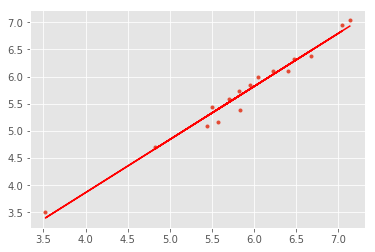

In [198]:
from lmfit.models import LinearModel
lm = LinearModel()
lm.param_names
ys = np.log10(data_def[is_histone.values][['S1','S2','S3']])
xs = np.log10(data_def[is_histone.values][['C1','C2','C3']])
x = xs.mean(skipna=True, axis=1)
y = ys.mean(skipna=True, axis=1)
std = ys.std(ddof=0, skipna=True, axis=1)
result  = lm.fit(y.values, x=x.values, weigthts=1/std.values)

plt.plot(x.values, y.values,  linestyle='None', marker='.')
#plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
result

## Go term analysis
Ae select protein with a log2 fold change greather than 1 between Senescent and control
for go term analysis we will be using david online and visualize the outputs.

Also, if possible, we will select the uniprot-sprot ID between the ids of a protein group as the uniprot-sprot are likely to be better annotated.

In [199]:
np.log10(data_def[is_histone.values][['ave_med','ave_exo']]).head()

,ave_med,ave_exo
index,,
2148,5.450718,5.504378
3533,5.385560,5.833067
3538,5.086725,5.436669
6046,6.942330,7.046964
7016,6.104421,6.406601


In [107]:
unknows = ['PAQR5_HUMAN','ITPI2_HUMAN','WLS_HUMAN','QTRT2_HUMAN']

def select_id(in_col):
    res = []
    for n in in_col:
        #print(n)
        temp = []
        item_list = n.split(';')
        for acc in item_list:
            #print (acc)
            if acc.count('|') >=2:
                temp_id = acc.split(' ')[0].split('|')[1]
                temp_type = acc.split(' ')[0].split('|')[0]
                #print (temp_type)
                if temp_type == 'sp' and temp_id:
                    temp.append(temp_id)
                    
                    break
        if len(temp) == 0:
            temp_id = item_list[0].split(' ')[0].split('|')[1]
            res.append(temp_id)
        else:
            res.append(temp[0])
    return res
             

df.columns
temp = df[['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
        'Gene names', 'Fasta headers', 'Number of proteins',
       'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths',
        'Q-value','Score']]
temp.head()
selection=data_def.join(temp,how='left')
selection['david_input']=select_id(selection['Fasta headers'])
selection[selection['logFC']<-0.38].sort_values('FDR').to_csv(TXT_PATH+'up_senescent_maxquant16660_4x.csv')

### David Chart
This is an enrichment analysis for all the annotation keywords stored in the david database.
It is the most similar approch to the classical GO-term enrichment analysis. With david database, we have the benefit to test not only the go annotation but also several other controlled vocabulary annotation such as Panther, OMIM disease, uniprot keywords and so on

In [108]:
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Unique peptides,Sequence coverage [%],Unique + razor sequence coverage [%],Unique sequence coverage [%],Mol. weight [kDa],Sequence length,Sequence lengths,Q-value,Score,david_input
index,,,,,,,,,,,,,,,,,,,,,
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,0_Q13286_CLN3_HUMAN,26339.750110,36911.054730,0.486811,...,3,8.4,8.4,8.4,47.6220,438,438;438;399;390;370;363;341;336;384;155;167;17...,0.000000,11.2050,Q13286
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,1_Q9H1N7_S35B3_HUMAN,27074.100389,35303.400844,0.382894,...,4,8.5,8.5,8.5,44.5920,401,401;369;251,0.000000,12.2760,Q9H1N7
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,2_A0A024R1R8_A0A024R1R8_HUMAN,184013.316250,154979.559558,-0.247732,...,1,14.1,14.1,14.1,7.0913,64,64;64,0.001689,2.2639,Q9Y2S6
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,3_A0A024R216_A0A024R216_HUMAN,279931.162210,257461.537165,-0.120715,...,5,36.0,23.6,23.6,22.6190,203,203;203;141;44,0.000000,21.0260,Q9Y3E1
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,4_A0A024R368_A0A024R368_HUMAN,31364.653378,27306.397316,-0.199901,...,2,2.1,2.1,2.1,95.6140,844,844;900;844;109;119;128;143;163;251;547;615;831,0.000000,4.0986,Q7Z3G6


In [109]:
david_chart = pd.read_table(TXT_PATH+'david\\'+'chart_CCC911C949E91559550575186.txt')
david_chart.columns
genes = david_chart.Genes
del david_chart['Genes']
print(david_chart.shape)
david_chart[['Category','Term','Count','PValue']].head(30)

(616, 12)


,Category,Term,Count,PValue
0,UP_KEYWORDS,Phosphoprotein,384,1.227580e-14
1,GOTERM_BP_DIRECT,GO:0030198~extracellular matrix organization,34,7.304809e-13
2,UP_KEYWORDS,Electron transport,20,4.612244e-09
3,UP_KEYWORDS,Mitochondrion,78,4.833420e-09
4,GOTERM_BP_DIRECT,GO:0030574~collagen catabolic process,16,1.410148e-08
5,UP_KEYWORDS,Respiratory chain,15,2.245043e-08
6,GOTERM_CC_DIRECT,GO:0005739~mitochondrion,91,2.616095e-08
7,UP_KEYWORDS,Extracellular matrix,29,8.482000e-08
8,GOTERM_BP_DIRECT,GO:0032981~mitochondrial respiratory chain com...,15,8.828118e-08
9,GOTERM_CC_DIRECT,GO:0005615~extracellular space,90,9.142211e-08


In [110]:
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Unique peptides,Sequence coverage [%],Unique + razor sequence coverage [%],Unique sequence coverage [%],Mol. weight [kDa],Sequence length,Sequence lengths,Q-value,Score,david_input
index,,,,,,,,,,,,,,,,,,,,,
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,0_Q13286_CLN3_HUMAN,26339.750110,36911.054730,0.486811,...,3,8.4,8.4,8.4,47.6220,438,438;438;399;390;370;363;341;336;384;155;167;17...,0.000000,11.2050,Q13286
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,1_Q9H1N7_S35B3_HUMAN,27074.100389,35303.400844,0.382894,...,4,8.5,8.5,8.5,44.5920,401,401;369;251,0.000000,12.2760,Q9H1N7
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,2_A0A024R1R8_A0A024R1R8_HUMAN,184013.316250,154979.559558,-0.247732,...,1,14.1,14.1,14.1,7.0913,64,64;64,0.001689,2.2639,Q9Y2S6
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,3_A0A024R216_A0A024R216_HUMAN,279931.162210,257461.537165,-0.120715,...,5,36.0,23.6,23.6,22.6190,203,203;203;141;44,0.000000,21.0260,Q9Y3E1
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,4_A0A024R368_A0A024R368_HUMAN,31364.653378,27306.397316,-0.199901,...,2,2.1,2.1,2.1,95.6140,844,844;900;844;109;119;128;143;163;251;547;615;831,0.000000,4.0986,Q7Z3G6


### David Cluster
Another peculiarity of david is to create cluster of similar keywords, that get togeter because they are releted to each other.

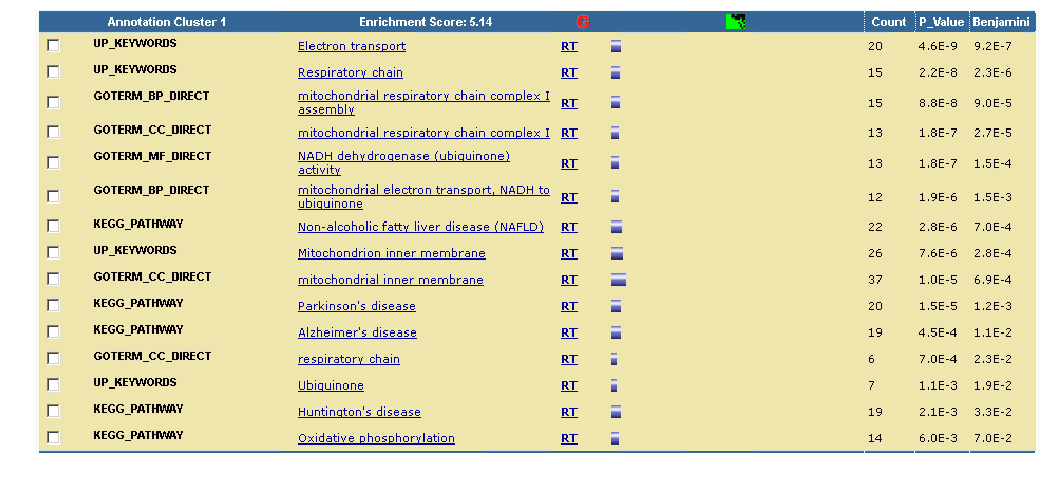

In [111]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_1.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

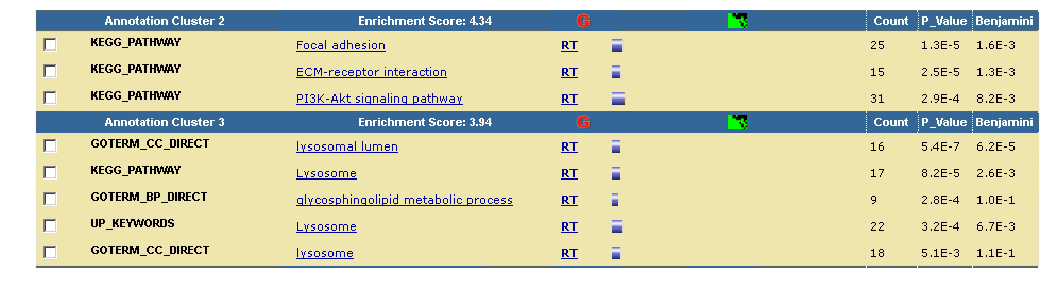

In [112]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_2.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

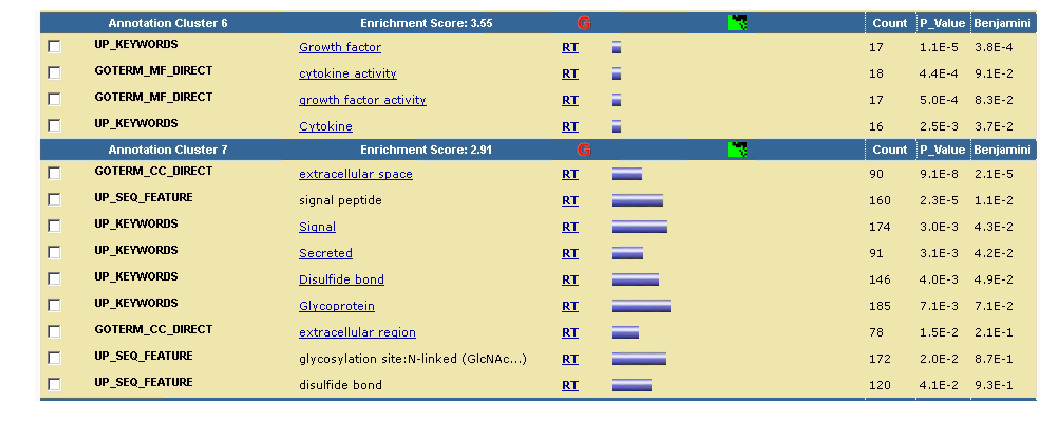

In [113]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_3.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()

In [114]:
sprot_features = pd.read_table(TXT_PATH+'uniprot//uniprot-yourlist.tab')

In [115]:
selection = selection.merge(sprot_features, left_on='david_input', right_on=sprot_features.columns[-2])
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,yourlist:M20190603E5A08BB0B2D1C45B0C7BC3B55FD265561B9C2B8,Gene ontology (cellular component)
0,40774.232752,41921.667862,44848.694362,27191.281257,25875.619985,29432.516358,17_G8JLL2_G8JLL2_HUMAN,42514.864992,27499.805867,-0.628546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G8JLL2,NaN
1,441263.699281,254407.321280,257036.463699,216091.680870,209985.397787,225540.012932,29_A0A075B7D9_A0A075B7D9_HUMAN,317569.161420,217205.697197,-0.548009,...,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN,NaN,NaN,CROSSLNK 265 265 Glycyl lysine isopeptide (Lys...,REGION 407 575 21 X approximate tandem repeats...,Q92804,cytoplasm [GO:0005737]; nucleoplasm [GO:000565...
2,217646.447183,260165.664563,257821.924582,122901.549372,121249.632916,116028.143934,61_A0A087WUF6_A0A087WUF6_HUMAN,245211.345443,120059.775407,-1.030273,...,SUBCELLULAR LOCATION: Secreted. Nucleus. Note=...,NaN,NaN,"PROPEP 1 142 Or 93, or 124, or 125, or 131, or...",NaN,NaN,CROSSLNK 228 228 Glycyl lysine isopeptide (Lys...,REGION 261 277 Heparin-binding. {ECO:0000250}.,P09038,extracellular region [GO:0005576]; extracellul...
3,356045.866018,353831.619408,341798.913901,196752.325688,152688.736989,200031.427351,77_Q99417_MYCBP_HUMAN,350558.799776,183157.496676,-0.936572,...,SUBCELLULAR LOCATION: Cytoplasm. Nucleus. Mito...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q99417,cytoplasm [GO:0005737]; mitochondrion [GO:0005...
4,35012.557553,36181.899880,32277.953965,19617.140568,18644.896998,18362.943718,79_A0A087WV88_A0A087WV88_HUMAN,34490.803799,18874.993761,-0.869736,...,SUBCELLULAR LOCATION: Membrane {ECO:0000256|Ru...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A087WV88,integral component of membrane [GO:0016021]


## Vulcano Plot with only selected proteins
we add transmembrane regions and signal peptide 

In [123]:
selection.to_csv(TXT_PATH+'def.csv')

In [117]:
selection = selection.replace(-np.inf,-4)
selection['log10p']=selection['log10p'].fillna(selection['log10p'].mean())
text_list = []
look_into = []
for n in selection.index.values:
    a=0
    text = selection['Protein names'].loc[n]
    text = text.split(' (')[0]
    text+='\n'
    #print (selection['Signal peptide'].loc[n])
    #if str(selection['Signal peptide'].loc[n]) != 'nan':
        #text+='has signal peptide\n'
        #a=1
    if str(selection['Transmembrane'].loc[n]) != 'nan':
        text+='has Transmembrane\n'
        a=1
    if a >0:
        look_into.append(n)
    
    text_list.append(text)   

In [118]:
selection.sort_values('FC').head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,yourlist:M20190603E5A08BB0B2D1C45B0C7BC3B55FD265561B9C2B8,Gene ontology (cellular component)
7,3.268990e+04,3.272504e+04,3.429659e+04,6351.884992,5581.547348,5293.056804,100_A0A087WW59_A0A087WW59_HUMAN,3.323718e+04,5742.163048,-2.533132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q7Z7L8,NaN
418,1.374902e+04,1.513794e+04,1.552632e+04,2665.260998,3328.516925,3613.193505,4460_P98066_TSG6_HUMAN,1.480442e+04,3202.323809,-2.208837,...,NaN,NaN,NaN,NaN,CARBOHYD 118 118 N-linked (GlcNAc...) asparagi...,DISULFID 58 127; DISULFID 82 103; DISULFID 135...,NaN,NaN,P98066,extracellular region [GO:0005576]; extracellul...
575,6.682856e+04,3.484169e+04,3.587424e+04,9970.066046,10316.830963,12670.309744,6501_Q93083_MT1L_HUMAN,4.584817e+04,10985.735584,-2.061233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGION 1 29 Beta.; REGION 30 61 Alpha.,Q93083,cytoplasm [GO:0005737]; nucleus [GO:0005634]; ...
369,1.442894e+06,1.867189e+06,1.736317e+06,412886.255286,400426.348228,413813.813768,3815_P35354_PGH2_HUMAN,1.682134e+06,409042.139094,-2.039971,...,SUBCELLULAR LOCATION: Microsome membrane; Peri...,NaN,NaN,NaN,CARBOHYD 53 53 N-linked (GlcNAc...) asparagine...,"DISULFID 21 32 {ECO:0000244|PDB:5F19, ECO:0000...",NaN,NaN,P35354,caveola [GO:0005901]; cytoplasm [GO:0005737]; ...
381,2.495413e+05,3.234982e+05,2.950079e+05,74790.810511,75044.716936,75849.844995,3929_P42830_CXCL5_HUMAN,2.893491e+05,75228.457481,-1.943461,...,SUBCELLULAR LOCATION: Secreted.,NaN,NaN,NaN,NaN,"DISULFID 49 75 {ECO:0000244|PDB:2MGS, ECO:0000...",NaN,NaN,P42830,extracellular region [GO:0005576]; extracellul...


In [125]:
annotations =  selection[['Protein names']]
annotations['Protein names'] = [n.split('(')[0].strip() for n in annotations['Protein names']]
#['Protein names']
#interactive plot 'logFC',y='log10p'
trace_1 = go.Scatter(
    x=selection.loc[look_into].logFC,
    y=selection.loc[look_into].log10p,
    mode='markers',
    name='Transmembrane',
    text = annotations['Protein names'].loc[look_into],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

#interactive plot 'logFC',y='log10p'
trace_2 = go.Scatter(
    x=selection[~selection.index.isin(look_into)].logFC,
    y=selection[~selection.index.isin(look_into)].log10p,
    mode='markers',
    name='the rest',
    text = annotations[~annotations.index.isin(look_into)]['Protein names'],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

layout = dict(title='Vulcano, Transmembrane',
             width=1000,
             height=800)

fig = go.Figure(data=[trace_1,trace_2], 
                layout=layout)
iplot(fig, filename='test')

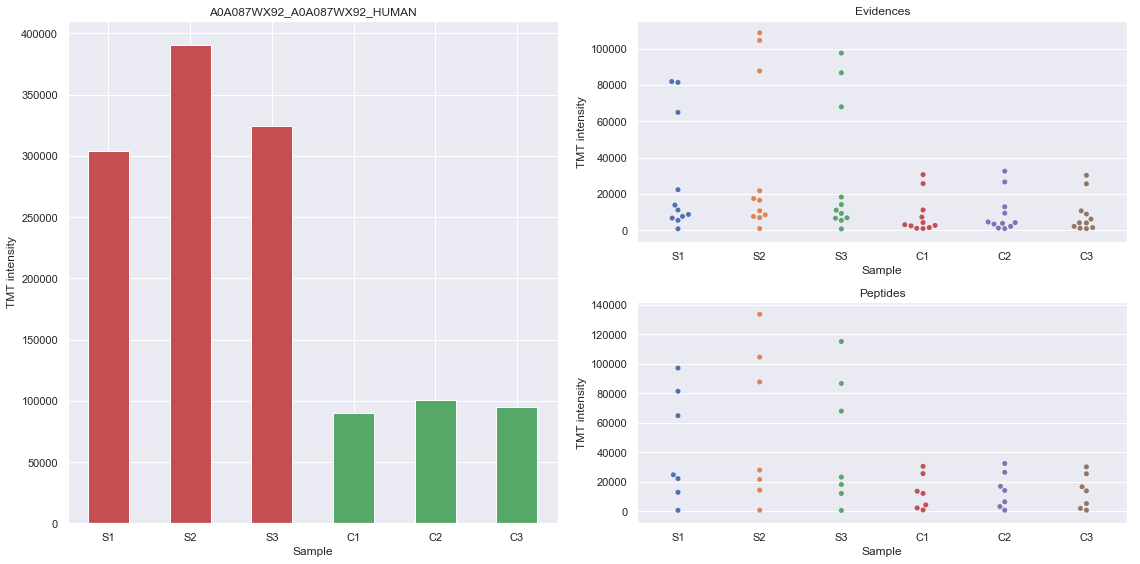

In [120]:
make_plot(prot_id= 123)

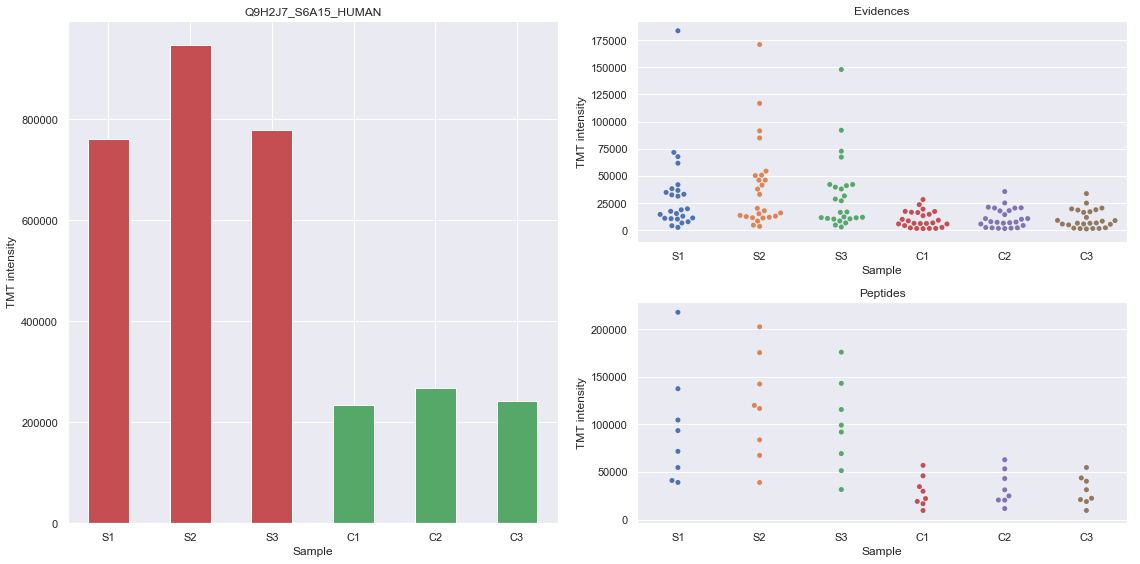

In [121]:
make_plot(prot_id= 7266)

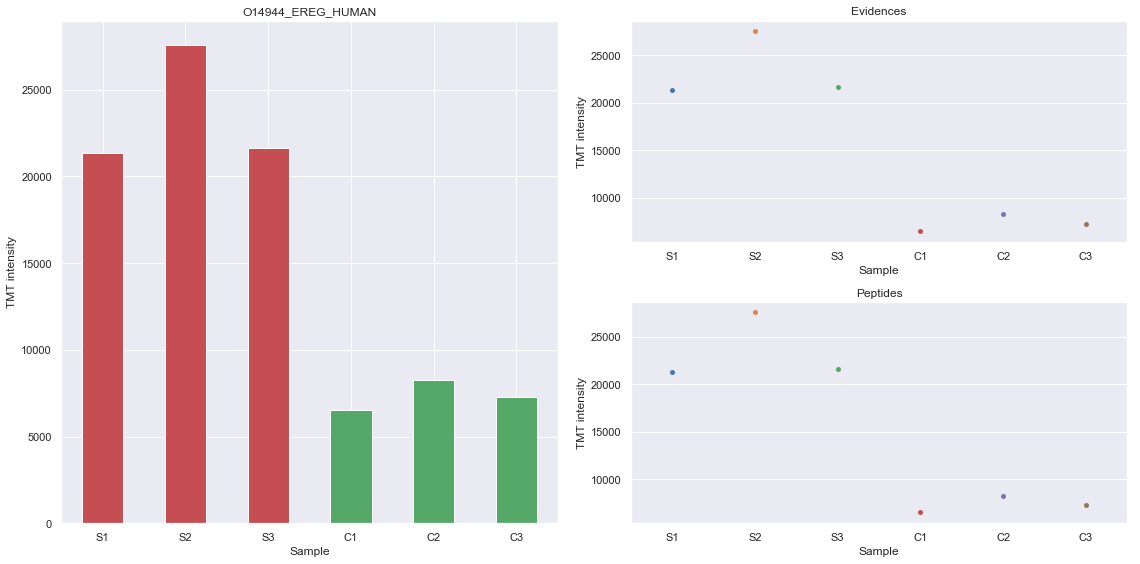

In [122]:
make_plot(prot_id= 2578)